In [1]:
import re
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
FontPath = "C:\\Windows\\Fonts\\meiryo.ttc"
jpfont = FontProperties(fname=FontPath)
from collections import defaultdict, Counter

import MeCab

from sklearn.feature_extraction.text import CountVectorizer

from gensim import corpora, models
from gensim.models import LdaModel, CoherenceModel

from PIL import Image
from wordcloud import WordCloud

In [2]:
df_all = pd.read_csv("df_last.csv")

for i in range(len(df_all)):
    if df_all["歌詞"][i] == "Not Found...":
        n = df_all.iloc[i,0]
        g = df_all.iloc[i,1]
        a = df_all.iloc[i,3]
        print(f"{n}回"+":"+f"({g})"+a)

2回:(童謡賞)ゆうらんバス_by_水上房子／キング小鳩会
3回:(新人奨励賞)団地のお嬢さん_by_山中みゆき
3回:(新人奨励賞)むすめ三度笠_by_蔵野たつ美
10回:(童謡賞)ペケの歌_by_長谷川よしみ
11回:(童謡賞)うまれたきょうだい１１人_by_スリー・バブルス
13回:(童謡賞)じんじん_by_ひばり児童合唱団
18回:(新人賞)雪ごもり_by_芦川よしみ
34回:(新人賞)今度私どこか連れていって下さいよ_by_加藤紀子
35回:(ミュージックビデオ賞)THE 8TH OF ACE_by_米米CLUB谷村新司


In [3]:
df_all

,回数,賞,ID,song_by,歌詞
0,1,大賞,181713,黒い花びら_by_水原弘,黒い花びら 静かに散った あの人は帰らぬ 遠い夢 俺は知ってる 恋の悲しさ 恋の苦しさ だか...
1,1,歌唱賞,42705,夜霧に消えたチャコ_by_フランク永井,俺のこころを 知りながら なんでだまって 消えたんだ チャコ チャコ 酒場に咲いた 花だけど...
2,1,童謡賞,No ID!,やさしい和尚さん_by_石井亀次郎とキングホウズキ会,和尚さん 和尚さん やさしい やさしい 和尚さん ひらひら もみじが ちってくる そうじゃよ...
3,2,大賞,13077,誰よりも君を愛す_by_松尾和子＆和田弘とマヒナスターズ,誰にも云われず たがいに誓った かりそめの恋なら 忘れもしようが ああ 夢ではない ただひと...
4,2,歌唱賞,14764,哀愁波止場_by_美空ひばり,夜の波止場にゃ 誰あれもいない 霧にブイの灯 泣くばかり おどま盆ぎり盆ぎり 盆からさきゃ ...
...,...,...,...,...,...
799,63,優秀作品賞,298572,Dream on the street_by_DA PUMP,指パッチン [Snap your fingers] リズム・マジック [Get up in ...
800,63,優秀作品賞,308342,根も葉もRumor_by_AKB48,Hey！ Whazzup？ Nothing！ Nothing！ Nothing！ Nothi...
801,63,優秀作品賞,299323,Backwards_by_三浦大知,始まりがなければ 終わりだってない 呼ばれ顔上げれば 目にかかる前髪 踏み出しても 変わらな...
802,63,優秀作品賞,307477,Happy!_by_氷川きよし,がんばりすぎて いつも 強がり 見栄張り 眠れない日も 絶えず 笑顔を ふりまいて そんな君...


In [4]:
#年ごとに歌詞リスト化
texts = []
t = []
n = 1

for i in range(len(df_all)):
    if df_all["歌詞"][i] != "Not Found..." :
        if df_all["回数"][i] == n: #全楽曲
            t.append(df_all["歌詞"][i])
        else:
            t = set(t) #重複削除
            texts.append(t)
            t = [df_all["歌詞"][i]]
            n = df_all["回数"][i]
            
        if i == len(df_all)-1:
            texts.append(t)
#平坦化            
for i in range(len(texts)):
    texts[i] = " ".join(texts[i])

In [5]:
#MeCab
def get_words(text):
    #ルビ部分の独立と記号除去
    text = text.replace("！", "!")
    text = text.replace("(", " ").replace(")", " ").replace("!", " ").replace("?", " ")
    text = p.sub('', text)
    
    m = MeCab.Tagger('/usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
    m.parse('') 
    node = m.parseToNode(text)
    word_list = []
    while node:
        pos = node.feature.split(",")[0]
        if pos in ["名詞"]: 
            w = node.surface
            word_list.append(w)
        elif pos in ["動詞", "形容詞"]:
            w = node.feature.split(",")[7]
            if "-" in w:
                w = w.split("-")[0]
            word_list.append(w)
        node = node.next
    
    #小文字化
    li = []
    for w in word_list:
        li.append(w.lower())
    
    #数字消す
    for w in li:
        if w.isdecimal():
            li.remove(w)
            
    #ひらがなカタカタの1文字消す
    for w in li:
        if len(w) == 1:
            if h.fullmatch(w) or k.fullmatch(w):
                li.remove(w)
                
    #ストップワード消す
    delete_words(li, d_li)
    delete_words(li, sloth_li)
    delete_words(li, sloth_lij)
    
    #英語消す
    li = delete_e(li)
    
    return li

In [6]:
def delete_words(li, d_li):
    for w in d_li:
        while w in li:
            li.remove(w)
            
#記号除去            
p = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥♪％]')

#ひらがなorカタカナ1文字のやつ消す
h = re.compile(r"[\u3041-\u309F]+")
k = re.compile(r'[\u30A1-\u30F4]+')
e = re.compile(r'[a-z]+')

#消したい文字
d_li = [
    "あー", "ああ", "アア", "アアア","みたい","とこ", "ない", "いい", "こと", "よう", "たび", "一", "ーーーア", "あの", "アッ", "あ", "あっ",
    "a","ah","uh","ooh","na", "is","the","from", "i","la","10", "5", "ツー", "ワン","ヨー",
       ]

#英語消す
def delete_e(li):
    n_li = []
    for w in li:
        if not e.fullmatch(w):
            n_li.append(w)
    return n_li

#ストップワード
#https://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/English.txt
#https://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt
sloth_e = pd.read_table("slothlib_e.txt")
sloth_j = pd.read_table("slothlib_j.txt")
sloth_li = [sloth_e["a"][i] for i in range(len(sloth_e))]
sloth_lij = [sloth_j["あそこ"][i] for i in range(len(sloth_j))]

In [7]:
#単語に分ける
docs = [get_words(i) for i in texts]

In [8]:
#各文書で、出現頻度が1回の単語削除
frequency = defaultdict(int)

for t in  docs:
    for w in t:
        frequency[w] += 1
        
docs = [[w for w in t if frequency[w] > 1] for t in docs]

In [9]:
#辞書化(単語ごとにID振り分け)
dic = corpora.Dictionary(docs)
dic.filter_extremes(no_below=3, no_above=0.7) #3文書以下に出てくるやつ、5割以上の文書に出てくるやつ除外
dic.compactify()
#print(dic.token2id)

In [10]:
print(len(dic))
#print(dic.token2id)

1774


In [11]:
#コーパス(bow)
bows = [dic.doc2bow(d) for d in docs]
bows = [sorted(w, key=lambda x:x[1], reverse=True) for w in bows] #降順にする

#コーパス(tf-idf)
tfidf_model = models.TfidfModel(bows, normalize = False)
tfidf = tfidf_model[bows]
tfidf = [sorted(w, key=lambda x:x[1], reverse=True) for w in tfidf] #降順にする

n = 50
#print(bows[n]) #単語の出現数
#print(tfidf[n]) #単語の出現数と、その単語の他の文書での出現数を加味したやつ
#print([[(dic[x[0]], x[1]) for x in w] for w in bows][n]) #単語をそのまま表示
#print([[(dic[x[0]], x[1]) for x in w] for w in tfidf][n]) #単語をそのまま表示

In [47]:
#print(texts)
#print(docs[0])
#print(len(dic.items()))
#print(dic.token2id)

#print(bows)

In [12]:
#R用
dic1 = pd.DataFrame(dic.token2id.keys(), columns = ["word"])
dic1.to_csv("dic_aa.csv", index = False)

pd.DataFrame(bows).to_csv("doc_aa.csv", index = False)
pd.DataFrame(tfidf).to_csv("tfidf_aa.csv", index = False)

In [65]:
#トピック数(perplexity)

perplexity = []
coherence = []
num_topic_range = range(1, 21)
for n in range(1, 21):
    lda_model = LdaModel(corpus=tfidf, id2word=dic, num_topics=n, passes=30, random_state=0)
    
    #perplexity
    per = np.exp(-lda_model.log_perplexity(tfidf))
    
    #coherence
    c = CoherenceModel(model=lda_model, texts=docs, dictionary=dic, coherence='u_mass')
    ch = c.get_coherence()
    
    perplexity.append(per)
    coherence.append(ch)
    
metrics = pd.DataFrame({'num_topic': num_topic_range, 'perplexity': perplexity, 'coherence': coherence})

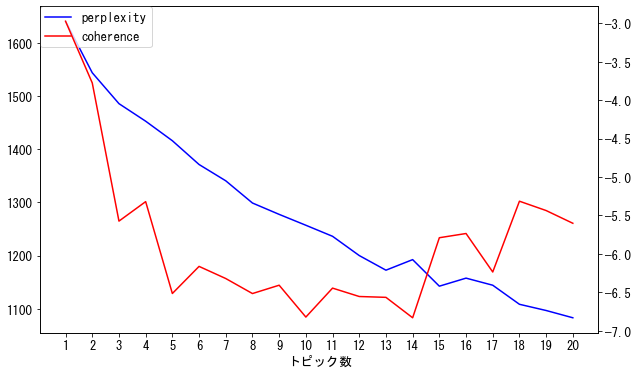

In [66]:
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 13
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
#fig.figsize=(20,6)
t_num=20
ax1.set_xticks(metrics["num_topic"][0:t_num])
ax1.plot(metrics["num_topic"][0:t_num], metrics["perplexity"][0:t_num], color = "b", label = "perplexity")
ax2.plot(metrics["num_topic"][0:t_num], metrics["coherence"][0:t_num], color = "r", label = "coherence")

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

ax1.set_xlabel("トピック数")
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
fig.savefig("pc_aa.png")

In [13]:
tn = 6

#LDA回してる
lda_model = LdaModel(corpus=tfidf, id2word=dic, num_topics=tn, passes=30, random_state=0)

#トピックの分布
lda_weights = lda_model[tfidf]

#トピック数の選択
#https://seedata.jp/blog-tech-264/

#コーパスの選択
#https://qiita.com/Spooky_Maskman/items/0d03ea499b88abf56819
#https://dev.classmethod.jp/articles/yoshim_2017ad_tfidf_1-2/

In [14]:
for t in range(tn):
    print("トピック"+str(t), end = "：")
    print(lda_model.print_topic(t,10))
    print("")

トピック0：0.007*"ヘイ" + 0.006*"最高" + 0.005*"母" + 0.005*"ラップ" + 0.005*"祭り" + 0.004*"薔薇" + 0.004*"キミ" + 0.004*"花束" + 0.003*"飛ぶ" + 0.003*"鐘"

トピック1：0.007*"さくら" + 0.005*"バイ" + 0.005*"カーニバル" + 0.004*"かもめ" + 0.003*"ゲーム" + 0.003*"感謝" + 0.003*"恋人" + 0.003*"乗る" + 0.003*"時代" + 0.003*"真夏"

トピック2：0.007*"暮れる" + 0.006*"足" + 0.006*"小指" + 0.005*"北国" + 0.005*"バラ" + 0.005*"ギター" + 0.004*"ママ" + 0.004*"飲む" + 0.004*"嫁" + 0.004*"歩"

トピック3：0.007*"さり気無い" + 0.006*"小さい" + 0.005*"走る" + 0.005*"脱ぎ捨てる" + 0.005*"熱" + 0.005*"父" + 0.005*"陽ざし" + 0.004*"触れる" + 0.003*"無情" + 0.003*"北"

トピック4：0.004*"虹" + 0.004*"ヘイ" + 0.004*"掴む" + 0.003*"未来" + 0.003*"答え" + 0.003*"進む" + 0.003*"一瞬" + 0.003*"起きる" + 0.003*"決める" + 0.003*"光"

トピック5：0.009*"螢" + 0.005*"乾杯" + 0.005*"番" + 0.005*"山" + 0.004*"坂" + 0.004*"浪花" + 0.004*"飛行" + 0.004*"右手" + 0.003*"ブルー" + 0.003*"日本"



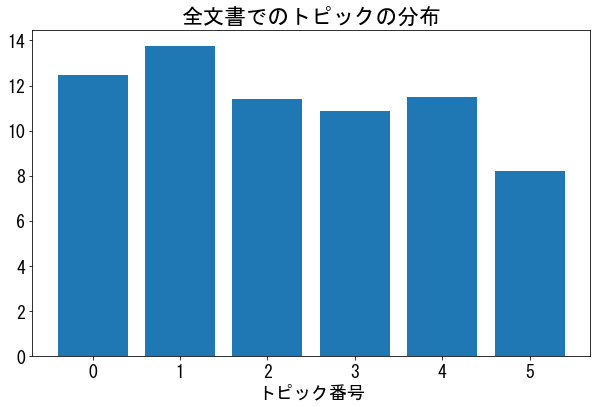

In [16]:
#全体のトピック分布
topic_weight = []
for t in range(tn):
    g = []
    for i in range(len(lda_weights)):
        w = 0
        for j in range(len(lda_weights[i])):
            if lda_weights[i][j][0] == t:
                w = lda_weights[i][j][1]
            g.append(w)
    tw = [str(t), sum(g)]
    topic_weight.append(tw)
df = pd.DataFrame(topic_weight,columns = ["トピック番号", "比率"])
plt.figure(figsize = (10,6))
plt.xlabel("トピック番号")
plt.title("全文書でのトピックの分布")
plt.bar(df["トピック番号"], df["比率"])

plt.savefig("C:/Users/hakuta.yuki/Documents/Latex/pict/topics_aa.png")

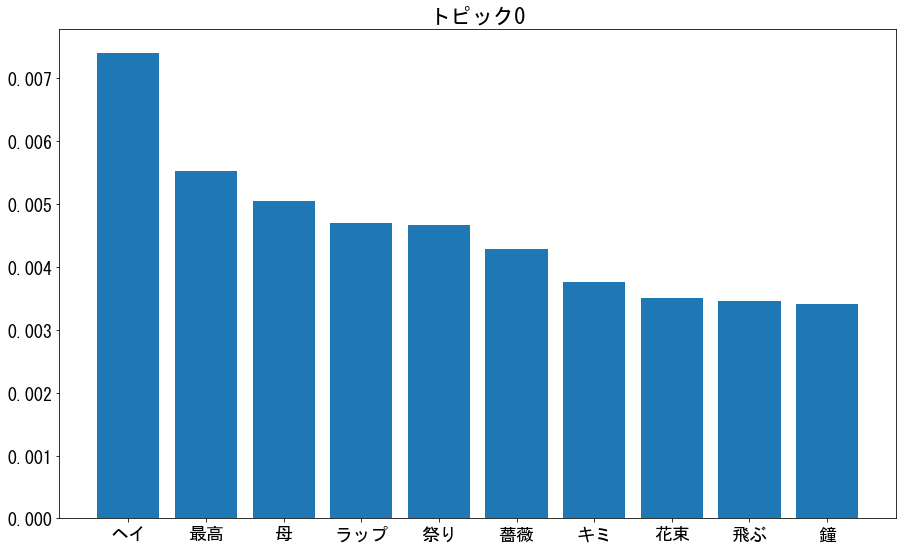

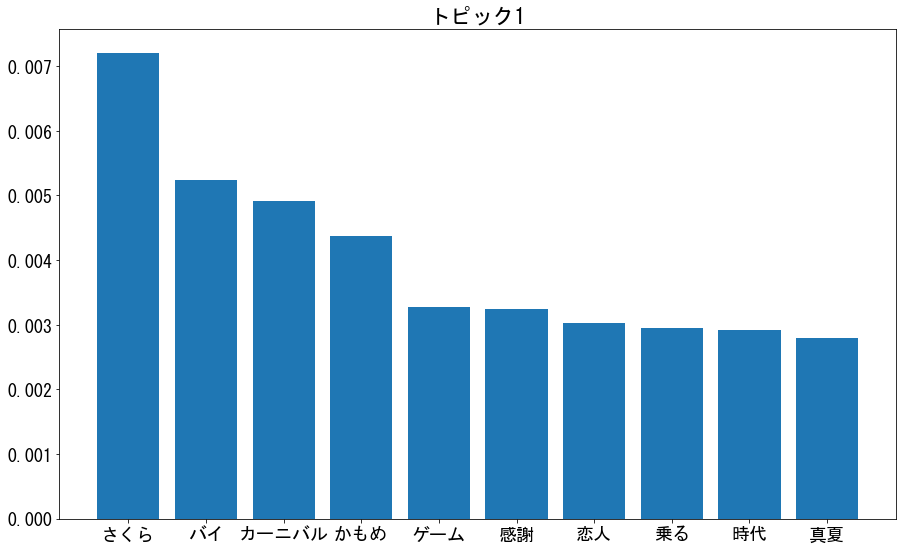

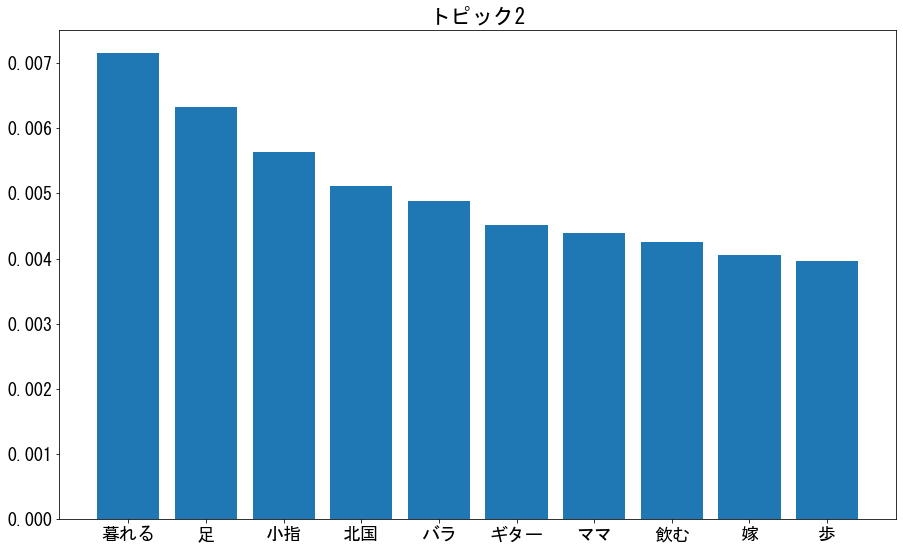

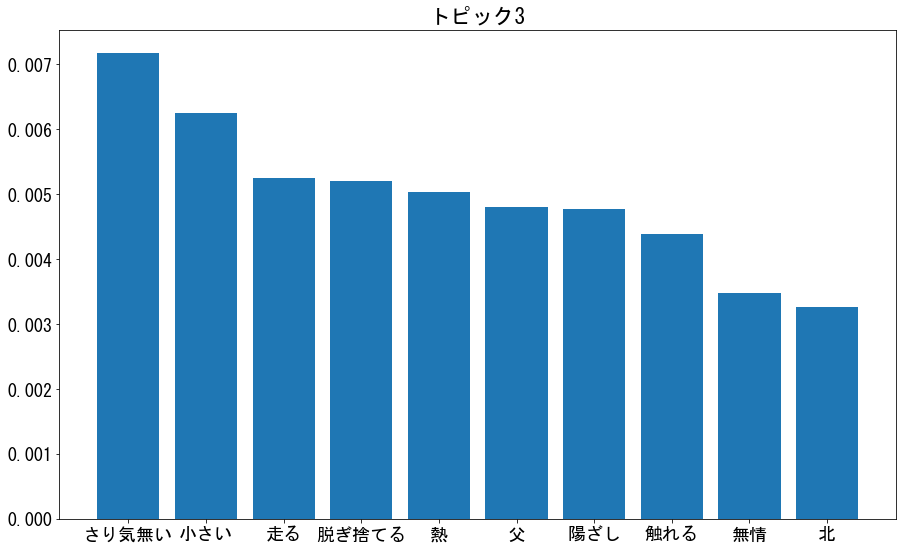

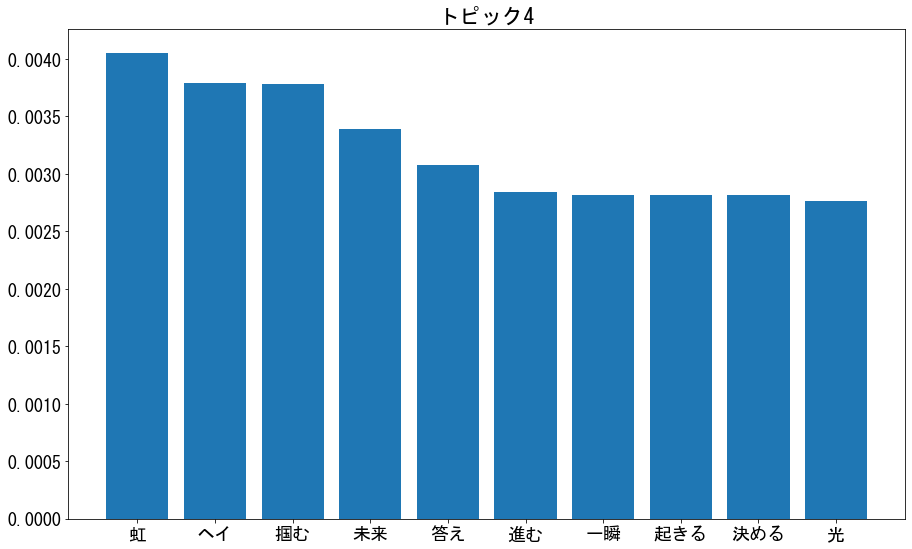

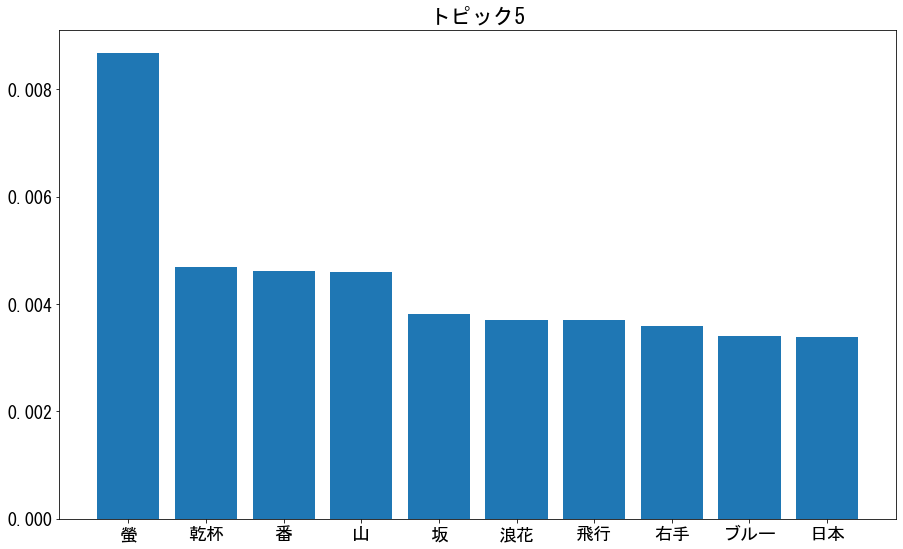

In [15]:
for i in range(tn):
    plt.rcParams['font.family'] = "MS Gothic"
    plt.rcParams["font.size"] = 18
    plt.figure(figsize = (15,9))
    plt.bar(dict(lda_model.show_topic(i,10)).keys(), dict(lda_model.show_topic(i,10)).values())
    plt.title(f"トピック{i}")
    plt.savefig(f"C:/Users/hakuta.yuki/Documents/Latex/pict/aa_{i}")

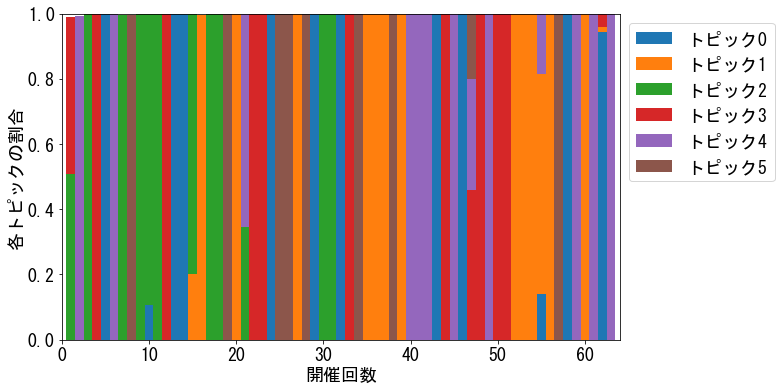

In [17]:
year = [i for i in range(1,64)]

labels = []
weights = []
for t in range(tn):
    g = []
    for i in range(len(lda_weights)):
        w = 0
        for j in range(len(lda_weights[i])):
            if lda_weights[i][j][0] == t:
                w = lda_weights[i][j][1]
        g.append(w)
    weights.append(g)
    labels.append(f"トピック{t}")

fig = plt.figure(figsize=(10,6))
#plt.stackplot(year,weights, labels=labels)
for t in range(tn):
    if t == 0:
        plt.bar(year,weights[t],label=labels[t], width=1.0)
        b = np.array(weights[t])
    else:
        plt.bar(year, weights[t], bottom=b, label=labels[t], width=1.0)
        b = b + np.array(weights[t])

plt.xlim(0,64)
plt.ylim(0,1.0)
plt.xlabel("開催回数")
plt.ylabel("各トピックの割合")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")
plt.savefig("C:/Users/hakuta.yuki/Documents/Latex/pict/stack_aa.png", bbox_inches='tight')

In [20]:
num = 53
print(texts[num])
print(docs[num])
print("")
print(lda_weights[num])

窓から射し込む たなびく一筋の 月光が部屋に灯(ひ)をともす あなたの言葉に 永遠を感じた そばにいるだけで こんなに幸せ 夜空に絵を描く 幾千の星より 数えきれぬほどの 愛ある日々の中で これからもあなたの 思い出を描いてゆきたい 出逢えたことにいま ありがとう 振り返りはしない 悲しい思い出は あなたに恋して 忘れたみたい やさし過ぎるところが 時々私を 不安にさせている こんなに好きなのに 激しく燃えるような 愛ではないけれど 静かに流れゆく 愛が胸で響く いつまでも二人で 思い出を描いてゆきたい 好きになってくれて ありがとう いつも いつまでも 出会った日のままの想い 忘れずに 二人いられるのなら 夜空に絵を描く 幾千の星より 数えきれぬほどの 愛ある日々の中で これからもあなたと 思い出を描いてゆきたい あなたに伝えたい ありがとう 本当に本当に 愛してる おんなは翳(かげ)ある 横顔みせて 西から流れて きたという 問わず語りの 身のうえ話 ひざをよせあう カウンター さすらいの さすらいの 酒をのむ こぼれ灯の こぼれ灯の 酒のやど 硝子戸ゆすって 雪が舞う おんなは数えて はたちと幾つ 男につくした 指を折る 遠(とう)のむかしに わかれた女(やつ)を 想い出させる そのしぐさ さすらいの さすらいの 酒をのむ こぼれ灯の こぼれ灯の 酒のやど 泣くなよ しみるぜ あの汽笛(きてき) おんなは離れの ちいさな部屋に 泊まって行ってと 下を向く 故郷(ふるさと)なくした 似た者どうし 夢のかけらが ほしい夜 さすらいの さすらいの 酒をのむ こぼれ灯の こぼれ灯の 酒のやど ゆらりとくずれる 酔いごころ 白い天使の歌が賑わう街を笑みで染め いま心のCandleに灯(ひ)を点してゆく 今年最高の Present あのとき ふたりが出会えたこと I Want To Show You Everything Tonight For Love それだけでイイ Beautiful Angel 星が奏でるMelodyに Beautiful Angel Oh, 永遠の愛を誓う Dance, Dance, Dance 街に流れるCarolに 心までDance Beautiful Angel ねぇ、いつまでも一緒にいてね If It's Together With Yo

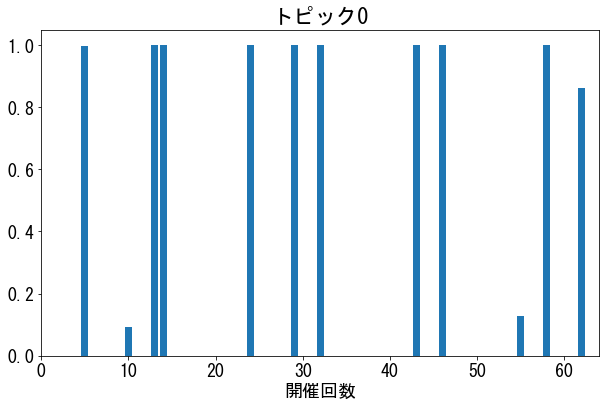

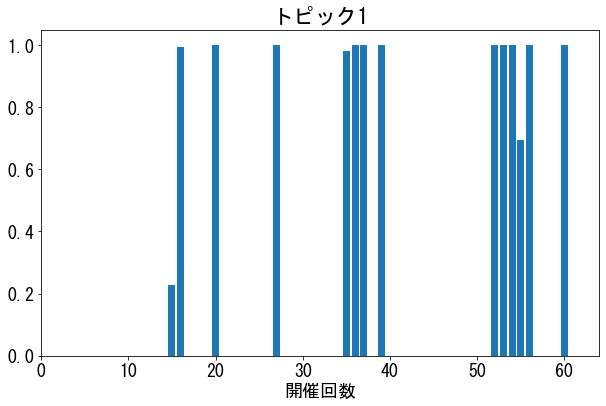

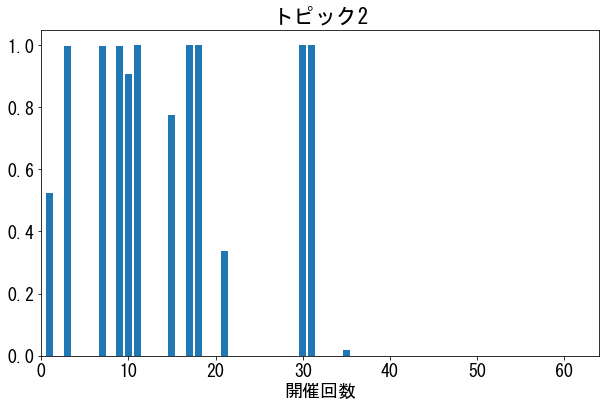

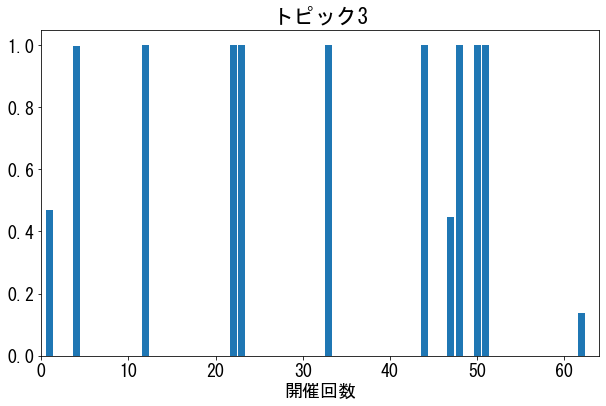

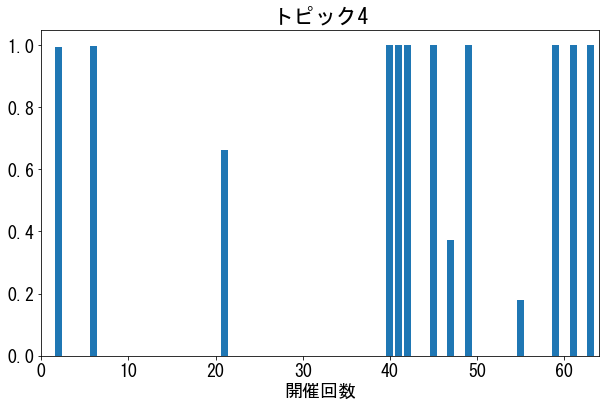

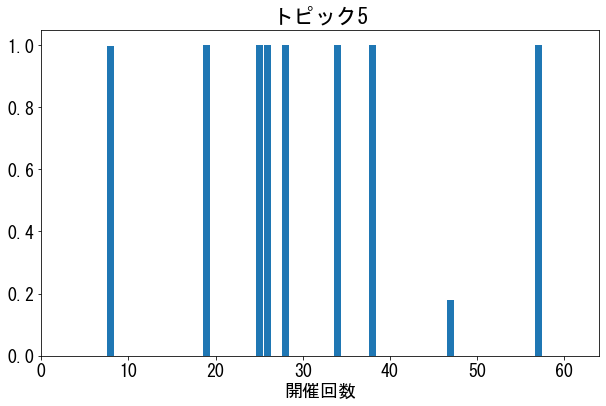

In [120]:
for t in range(tn):
    g = []
    for i in range(len(lda_weights)):
        w = 0
        for j in range(len(lda_weights[i])):
            if lda_weights[i][j][0] == t:
                w = lda_weights[i][j][1]
        g.append(w)

    df_topic= pd.DataFrame(g)

    plt.figure(figsize=(10,6))
    plt.bar(year, g)
    plt.xlim(0,64)
    plt.xlabel("開催回数")
    plt.title(f"トピック{t}")
    plt.savefig(f"C:/Users/hakuta.yuki/Documents/Latex/pict/gene_aa_{t}")

In [ ]:
msk = np.array(Image.open("chikuonki.png"))
for i in range(tn):
    wordcloud = WordCloud(
        background_color="white",
        font_path="C:\\Windows\\Fonts\\meiryo.ttc",
        width=375, height=250,
        mask = msk,
        contour_width=4,
        contour_color="grey",
    ).generate_from_frequencies(dict(lda_model.show_topic(i,50)))

    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(wordcloud)

#イラスト
#https://www.ac-illust.com/main/detail.php?id=139363&word=%E8%93%84%E9%9F%B3%E6%A9%9F

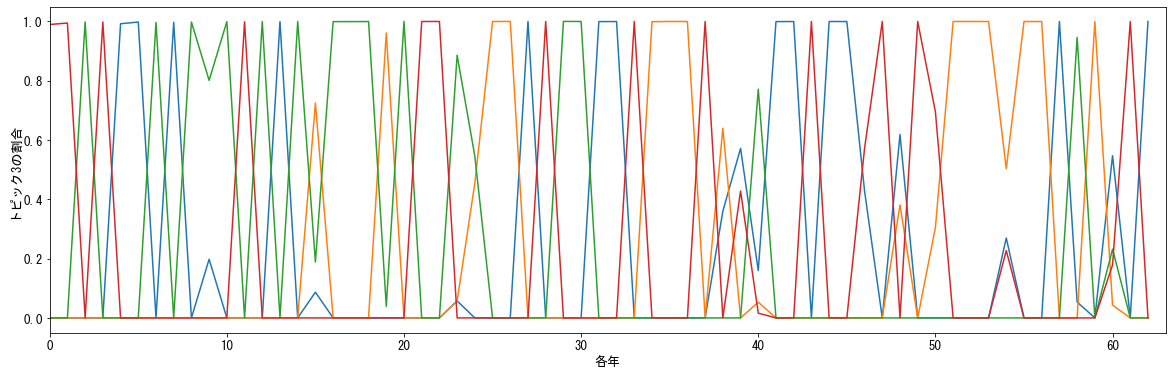

In [37]:
plt.figure(figsize=(20,6))
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 13
plt.xlabel("各年")
plt.xlim(0,63)
plt.ylabel(f"トピック{t}の割合")

for t in range(tn):
    g = []
    for i in range(len(lda_weights)):
        w = 0
        for j in range(len(lda_weights[i])):
            if lda_weights[i][j][0] == t:
                w = lda_weights[i][j][1]
        g.append(w)

    df_topic= pd.DataFrame(g)

    
    plt.plot(df_topic)

In [ ]:
for t in range(tn):
    g = []
    for i in range(len(lda_weights)):
        w = 0
        for j in range(len(lda_weights[i])):
            if lda_weights[i][j][0] == t:
                w = lda_weights[i][j][1]
        g.append(w)

    df_topic= pd.DataFrame(g)

    plt.figure(figsize=(20,6))
    plt.plot(df_topic)
    plt.xlabel("各年")
    plt.xlim(0,63)
    plt.ylabel(f"トピック{t}の割合")